In [68]:
# Using Facebook's Prophet package to do some time series analysis on FBI gen violence data
# packages
import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from statistics import stdev, mean
from spectrum import *
from matplotlib import pyplot

In [22]:
predf = pd.read_csv("data/database_homicide1980-2014_FBI.csv", low_memory=False)
predf.head()

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,...,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI


In [47]:
df = predf[predf['Perpetrator Count'] > -1]
df = df[df['Weapon'] == "Handgun"]
df = df[df['Crime Type'] == "Murder or Manslaughter"]
df.head()

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
14,15,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,August,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Handgun,0,0,FBI
15,16,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,August,3,Murder or Manslaughter,...,Unknown,Female,29,Black,Unknown,Ex-Husband,Handgun,0,0,FBI
18,19,AK00106,Nome,Municipal Police,Nome,Alaska,1980,June,1,Murder or Manslaughter,...,Unknown,Male,33,Native American/Alaska Native,Unknown,Acquaintance,Handgun,0,0,FBI
19,20,AK00113,Bethel,Municipal Police,Bethel,Alaska,1980,February,1,Murder or Manslaughter,...,Unknown,Male,35,Native American/Alaska Native,Unknown,Brother,Handgun,0,0,FBI
25,26,AK00123,Kenai,Municipal Police,Kenai Peninsula,Alaska,1980,February,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Wife,Handgun,0,0,FBI


In [48]:
monthDict = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6,
            'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December': 12}
df['Month'] = df.Month.map(monthDict).map(int).map(lambda x: str(x) if x > 9 else "0" + str(x))
df['Year'] = df.Year.map(str)
df['DS'] = df['Year'] + "-" + df['Month']

In [49]:
crimes_month = df.groupby(['DS'])['Incident'].count()
crimes_month = pd.DataFrame(crimes_month)
crimes_month = crimes_month.reset_index()
crimes_month = crimes_month.rename({'DS':'ds', 'Incident':'y'}, axis = 'columns')
crimes_month.head()

,ds,y
0,1980-01,911
1,1980-02,799
2,1980-03,802
3,1980-04,839
4,1980-05,879


In [50]:
#std = stdev(crimes_month.y)
#avg = mean(crimes_month.y)
#crimes_month.y = (crimes_month.y - avg)/std

In [63]:
premodel = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False,
               seasonality_mode='multiplicative').fit(crimes_month)
prefuture = premodel.make_future_dataframe(periods = 0, freq = 'M')
prefcst = premodel.predict(prefuture)

In [77]:
p = Periodogram(crimes_month.y - prefcst.trend, sampling=1/(60*60*24*30))
p.run()

Text(0.5,0,'Months')

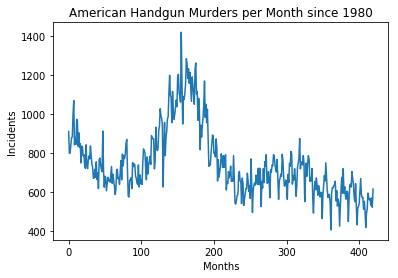

In [74]:
matplotlib.pyplot.plot(crimes_month.y)
matplotlib.pyplot.title("American Handgun Murders per Month since 1980")
matplotlib.pyplot.ylabel("Incidents")
matplotlib.pyplot.xlabel("Months")

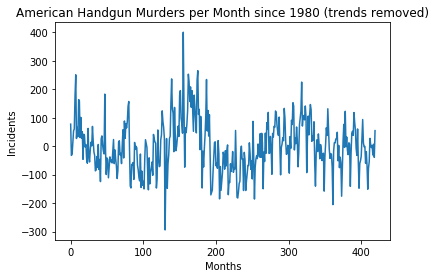

In [75]:
matplotlib.pyplot.title("American Handgun Murders per Month since 1980 (trends removed)")
matplotlib.pyplot.ylabel("Incidents")
matplotlib.pyplot.xlabel("Months")
matplotlib.pyplot.plot(crimes_month.y - prefcst.trend)

Text(0.5,1,'Fourier Analysis of Gun Crime Data')

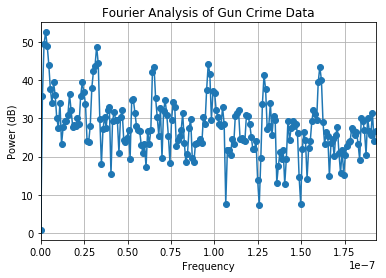

In [79]:
p.plot(marker='o')
matplotlib.pyplot.title("Fourier Analysis of Gun Crime Data")

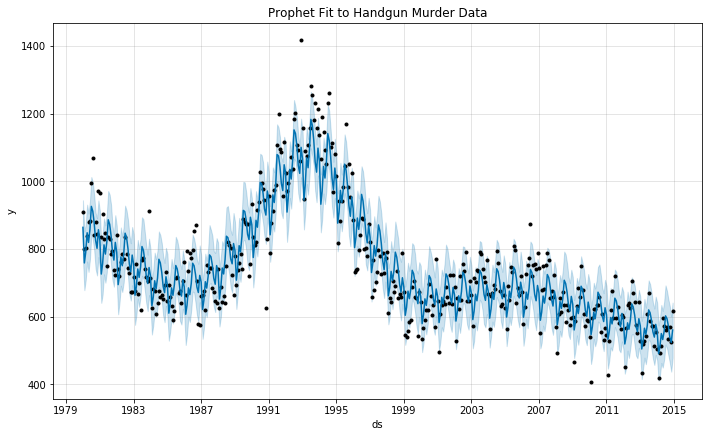

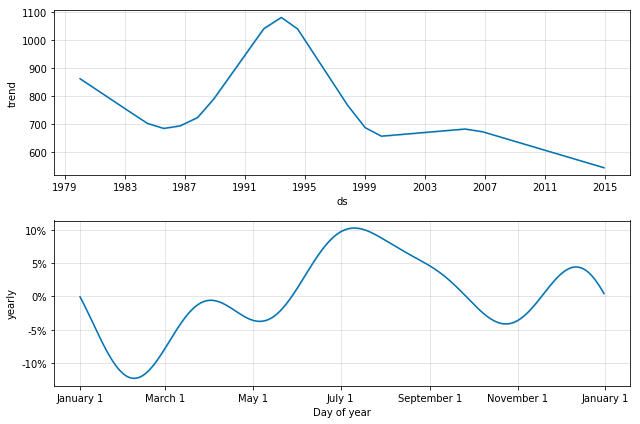

In [88]:
model = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=4,
               seasonality_mode='multiplicative').fit(crimes_month)
future = model.make_future_dataframe(periods = 0, freq = 'M')
fcst = model.predict(future)
fig1 = model.plot(fcst)
matplotlib.pyplot.title("Prophet Fit to Handgun Murder Data")
fig2 = model.plot_components(fcst)

In [86]:
df_cv = cross_validation(model, initial='3650 days', period='360 days', horizon = '365 days')
df_p = performance_metrics(df_cv, metrics=['mse', 'rmse', 'mae', 'mape', 'coverage'])
df_p.aggregate('mean')

INFO:fbprophet:Making 25 forecasts with cutoffs between 1990-04-06 00:00:00 and 2013-12-01 00:00:00


horizon     200 days 22:29:40.073800
mse                          15120.1
rmse                         121.613
mae                          94.5109
mape                        0.126924
coverage                    0.552742
dtype: object